****Import initial required packages****

In [1]:
import numpy as np
import matplotlib.pyplot as plt

****Import TF2****

In [2]:
import tensorflow as tf
# required for solving issue with cuDNN
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

****Import Keras****

In [3]:
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


****Import VGG16 network****

In [4]:
model = VGG16(weights='imagenet')

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

****Load image****

In [6]:
img_filename = 'dogs/dog_1.jpeg'

In [7]:
img = image.load_img(img_filename, target_size=(224, 224))

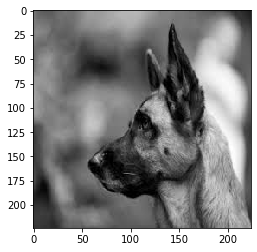

In [8]:
plt.imshow(img)

In [9]:
x = image.img_to_array(img)

In [10]:
print(x)

[[[114. 114. 114.]
  [113. 113. 113.]
  [111. 111. 111.]
  ...
  [ 31.  31.  31.]
  [ 29.  29.  29.]
  [ 29.  29.  29.]]

 [[114. 114. 114.]
  [113. 113. 113.]
  [111. 111. 111.]
  ...
  [ 32.  32.  32.]
  [ 29.  29.  29.]
  [ 29.  29.  29.]]

 [[115. 115. 115.]
  [114. 114. 114.]
  [112. 112. 112.]
  ...
  [ 33.  33.  33.]
  [ 31.  31.  31.]
  [ 31.  31.  31.]]

 ...

 [[ 51.  51.  51.]
  [ 51.  51.  51.]
  [ 51.  51.  51.]
  ...
  [160. 160. 160.]
  [147. 147. 147.]
  [147. 147. 147.]]

 [[ 51.  51.  51.]
  [ 51.  51.  51.]
  [ 51.  51.  51.]
  ...
  [158. 158. 158.]
  [159. 159. 159.]
  [159. 159. 159.]]

 [[ 51.  51.  51.]
  [ 51.  51.  51.]
  [ 51.  51.  51.]
  ...
  [154. 154. 154.]
  [165. 165. 165.]
  [165. 165. 165.]]]


In [11]:
x.shape

(224, 224, 3)

In [12]:
x = np.expand_dims(x, axis=0)

In [13]:
x.shape

(1, 224, 224, 3)

****Apply to the input image all required preprocessing steps (e.g. scaling) applied to the images on which VGG16 was trained****

In [14]:
x = preprocess_input(x)

In [15]:
print(x)

[[[[ 10.060997   -2.7789993  -9.68     ]
   [  9.060997   -3.7789993 -10.68     ]
   [  7.060997   -5.7789993 -12.68     ]
   ...
   [-72.939     -85.779     -92.68     ]
   [-74.939     -87.779     -94.68     ]
   [-74.939     -87.779     -94.68     ]]

  [[ 10.060997   -2.7789993  -9.68     ]
   [  9.060997   -3.7789993 -10.68     ]
   [  7.060997   -5.7789993 -12.68     ]
   ...
   [-71.939     -84.779     -91.68     ]
   [-74.939     -87.779     -94.68     ]
   [-74.939     -87.779     -94.68     ]]

  [[ 11.060997   -1.7789993  -8.68     ]
   [ 10.060997   -2.7789993  -9.68     ]
   [  8.060997   -4.7789993 -11.68     ]
   ...
   [-70.939     -83.779     -90.68     ]
   [-72.939     -85.779     -92.68     ]
   [-72.939     -85.779     -92.68     ]]

  ...

  [[-52.939003  -65.779     -72.68     ]
   [-52.939003  -65.779     -72.68     ]
   [-52.939003  -65.779     -72.68     ]
   ...
   [ 56.060997   43.221      36.32     ]
   [ 43.060997   30.221      23.32     ]
   [ 43.060997  

In [16]:
preds = model.predict(x)

****Keep the top 3 predictions****

In [17]:
decode_predictions(preds, top=3)[0]

[('n02109047', 'Great_Dane', 0.8439459),
 ('n02106662', 'German_shepherd', 0.11556178),
 ('n02088466', 'bloodhound', 0.02179054)]

In [18]:
predicted_class_index = np.argmax(preds[0])

In [19]:
print(predicted_class_index)

246


In [20]:
predicted_output = model.output[:, predicted_class_index]

In [21]:
print(predicted_output)

Tensor("strided_slice:0", shape=(None,), dtype=float32)


****Get the last convolutional layer of the model****

In [22]:
last_conv_layer = model.get_layer('block5_conv3')

In [23]:
print(last_conv_layer)

In [24]:
last_conv_layer.output

<tf.Tensor 'block5_conv3/Relu:0' shape=(None, 14, 14, 512) dtype=float32>

****Grad-CAM process****

In [25]:
from keras import backend as K

****Set function for calculating the gradient of the output w.r.t the pixels of the feature maps of the model's last convolutional layer****

In [26]:
grads = K.gradients(predicted_output, last_conv_layer.output)[0]

In [27]:
print(grads)

Tensor("gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(None, 14, 14, 512), dtype=float32)


****Apply GAP to the gradients****

In [28]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [29]:
print(pooled_grads)

Tensor("Mean:0", shape=(512,), dtype=float32)


****Use .function() of Keras backend for actually calculating the required outputs for a specific input****

In [30]:
f = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [31]:
print(f)

****Actually calculate outputs for input, i.e. execute f****

In [32]:
pooled_grads_value, conv_layer_output_value = f([x])

In [33]:
print(type(pooled_grads_value))

<class 'numpy.ndarray'>


In [34]:
print(pooled_grads_value.shape)

(512,)


In [35]:
print(type(conv_layer_output_value))

<class 'numpy.ndarray'>


In [36]:
print(conv_layer_output_value.shape)

(14, 14, 512)


In [37]:
n_channels = conv_layer_output_value.shape[-1]
n_channels

512

****Calculate the weighted linear combination of feature maps of the last conv layer****

In [38]:
for i in range(n_channels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [39]:
print(conv_layer_output_value.shape)

(14, 14, 512)


In [40]:
heatmap = np.mean(conv_layer_output_value, axis=2)

In [41]:
print(type(heatmap))

<class 'numpy.ndarray'>


In [42]:
print(heatmap.shape)

(14, 14)


In [43]:
print(heatmap)

[[ 3.2162011e-06  2.1766054e-06  2.6314683e-06  2.4564276e-06
   2.4968435e-06  2.9916093e-06  4.5399647e-06  6.3147118e-06
   6.3139591e-06  3.6087135e-06  3.7070088e-06  3.1386394e-06
   1.5551500e-06  2.7709743e-06]
 [ 6.0452351e-07  9.2295920e-08  3.8476696e-07  3.9468634e-07
   3.4265543e-07  1.7425135e-06  3.7784221e-06  5.0378121e-06
   3.5825619e-06  2.9183325e-06  1.4507184e-06  5.6853497e-07
   6.6657344e-07  7.4794178e-07]
 [ 1.2763384e-06  8.5906856e-07  1.6450590e-06  1.9164590e-06
   1.5949624e-06  2.4000556e-06  6.3642319e-06  7.3024680e-06
   6.9813650e-06  6.6012708e-06  3.5398086e-06  1.2419711e-06
   1.5503725e-06  3.4212085e-06]
 [ 1.1829192e-06  7.0445799e-07  1.7954798e-06  2.2593961e-06
   2.5737897e-06  2.0144357e-06  4.5757870e-06  5.2433634e-06
   7.8615731e-06  6.2280046e-06  3.4577674e-06  2.2062422e-06
   1.3366409e-06  2.8884451e-06]
 [ 1.1358318e-06  5.2625364e-07  1.1502702e-06  1.0545259e-06
   1.5345648e-06  1.4368618e-06  2.6761049e-06  2.1963949e-06


****Apply ReLU****

In [44]:
heatmap = tf.nn.relu(heatmap).numpy()
# alternatively heatmap = np.maximum(heatmap, 0)

In [45]:
print(type(heatmap))

<class 'numpy.ndarray'>


In [46]:
print(heatmap.shape)

(14, 14)


In [47]:
print(heatmap)

[[3.2162011e-06 2.1766054e-06 2.6314683e-06 2.4564276e-06 2.4968435e-06
  2.9916093e-06 4.5399647e-06 6.3147118e-06 6.3139591e-06 3.6087135e-06
  3.7070088e-06 3.1386394e-06 1.5551500e-06 2.7709743e-06]
 [6.0452351e-07 9.2295920e-08 3.8476696e-07 3.9468634e-07 3.4265543e-07
  1.7425135e-06 3.7784221e-06 5.0378121e-06 3.5825619e-06 2.9183325e-06
  1.4507184e-06 5.6853497e-07 6.6657344e-07 7.4794178e-07]
 [1.2763384e-06 8.5906856e-07 1.6450590e-06 1.9164590e-06 1.5949624e-06
  2.4000556e-06 6.3642319e-06 7.3024680e-06 6.9813650e-06 6.6012708e-06
  3.5398086e-06 1.2419711e-06 1.5503725e-06 3.4212085e-06]
 [1.1829192e-06 7.0445799e-07 1.7954798e-06 2.2593961e-06 2.5737897e-06
  2.0144357e-06 4.5757870e-06 5.2433634e-06 7.8615731e-06 6.2280046e-06
  3.4577674e-06 2.2062422e-06 1.3366409e-06 2.8884451e-06]
 [1.1358318e-06 5.2625364e-07 1.1502702e-06 1.0545259e-06 1.5345648e-06
  1.4368618e-06 2.6761049e-06 2.1963949e-06 4.9897108e-06 7.2823877e-06
  8.7087392e-06 4.5339775e-06 9.7441875e-07 

****Normalize in [0,1]****

In [48]:
max_heatmap_value = np.max(heatmap)
max_heatmap_value

2.3140568e-05

In [49]:
heatmap /= max_heatmap_value

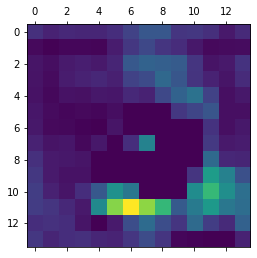

In [50]:
plt.matshow(heatmap)

****Mask the original image with the generated CAM heatmap****

In [51]:
import cv2

In [52]:
x_cv2 = cv2.imread(img_filename)

****Resize heatmap to match the dimensions of the image****

In [53]:
heatmap.shape

(14, 14)

In [54]:
heatmap = cv2.resize(heatmap, (x_cv2.shape[1], x_cv2.shape[0]))

In [55]:
heatmap.shape

(195, 258)

In [56]:
heatmap

array([[0.1389854 , 0.1389854 , 0.1389854 , ..., 0.1197453 , 0.1197453 ,
        0.1197453 ],
       [0.1389854 , 0.1389854 , 0.1389854 , ..., 0.1197453 , 0.1197453 ,
        0.1197453 ],
       [0.1389854 , 0.1389854 , 0.1389854 , ..., 0.1197453 , 0.1197453 ,
        0.1197453 ],
       ...,
       [0.16170156, 0.16170156, 0.16170156, ..., 0.09760147, 0.09760147,
        0.09760147],
       [0.16170156, 0.16170156, 0.16170156, ..., 0.09760147, 0.09760147,
        0.09760147],
       [0.16170156, 0.16170156, 0.16170156, ..., 0.09760147, 0.09760147,
        0.09760147]], dtype=float32)

In [57]:
heatmap.dtype

dtype('float32')

****Convert to RGB values in [0,255]****

In [58]:
heatmap_init = heatmap.copy()

In [59]:
heatmap = np.uint8(heatmap * 255)

In [60]:
heatmap.dtype

dtype('uint8')

In [61]:
heatmap

array([[35, 35, 35, ..., 30, 30, 30],
       [35, 35, 35, ..., 30, 30, 30],
       [35, 35, 35, ..., 30, 30, 30],
       ...,
       [41, 41, 41, ..., 24, 24, 24],
       [41, 41, 41, ..., 24, 24, 24],
       [41, 41, 41, ..., 24, 24, 24]], dtype=uint8)

In [62]:
print(heatmap.shape)

(195, 258)


In [63]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap

array([[[255,  12,   0],
        [255,  12,   0],
        [255,  12,   0],
        ...,
        [248,   0,   0],
        [248,   0,   0],
        [248,   0,   0]],

       [[255,  12,   0],
        [255,  12,   0],
        [255,  12,   0],
        ...,
        [248,   0,   0],
        [248,   0,   0],
        [248,   0,   0]],

       [[255,  12,   0],
        [255,  12,   0],
        [255,  12,   0],
        ...,
        [248,   0,   0],
        [248,   0,   0],
        [248,   0,   0]],

       ...,

       [[255,  36,   0],
        [255,  36,   0],
        [255,  36,   0],
        ...,
        [224,   0,   0],
        [224,   0,   0],
        [224,   0,   0]],

       [[255,  36,   0],
        [255,  36,   0],
        [255,  36,   0],
        ...,
        [224,   0,   0],
        [224,   0,   0],
        [224,   0,   0]],

       [[255,  36,   0],
        [255,  36,   0],
        [255,  36,   0],
        ...,
        [224,   0,   0],
        [224,   0,   0],
        [224,   0,   0]]

****Overlay heamap on the image. Here 0.5 represents intensity****

In [64]:
x_cv2.dtype

dtype('uint8')

In [65]:
heatmap.dtype

dtype('uint8')

In [66]:
x_masked = (heatmap * 0.4) + x_cv2

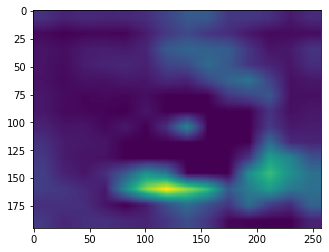

In [67]:
plt.imshow(heatmap_init)

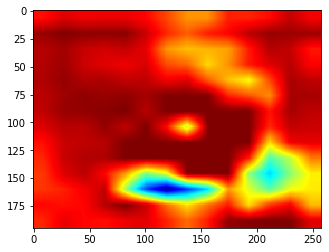

In [68]:
plt.imshow(heatmap)

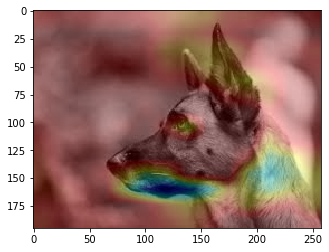

In [69]:
plt.imshow(keras.preprocessing.image.array_to_img(x_masked))